In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
"""
sequence data-data tht comes in a particular order
"""
#df_1 = pd.read_csv('apple_stock.csv', parse_dates=True, index_col=[0])

'\nsequence data-data tht comes in a particular order\n'

In [3]:
#df_1.head()

In [4]:
df_1 = pd.read_csv('apple_2012_1_1-2019_12_17.csv', parse_dates=True, index_col=[0])

In [5]:
apple_training = df_1['2012-1-1':'2018-1-1']

In [6]:
apple_training.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,14.732142,14.607142,14.621428,14.686786,302220800.0,12.669562
2012-01-04,14.810000,14.617143,14.642858,14.765715,260022000.0,12.737655
2012-01-05,14.948215,14.738214,14.819643,14.929643,271269600.0,12.879071
2012-01-06,15.098214,14.972143,14.991786,15.085714,318292800.0,13.013705
2012-01-09,15.276786,15.048214,15.196428,15.061786,394024400.0,12.993064


In [7]:
apple_training_processed = apple_training['Close']

In [8]:
df = pd.DataFrame(apple_training_processed)

In [9]:
print(df.shape)
print(len(df) *0.2) 

(1509, 1)
301.8


## Train Test Split

In [10]:
test_percent = 0.2 
len(df) * test_percent
test_point = np.round(len(df) * test_percent)
test_ind = int(len(df) - test_point)
train = df.iloc[:test_ind]
test = df.iloc[test_ind:] #test_ind point and go to end
train.shape, test.shape

((1207, 1), (302, 1))

## Normalize Data

In [11]:
#nned to scale label b/c it's being fed back into neuron
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0, 1))
scaler.fit_transform(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [12]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

Using TensorFlow backend.


In [13]:
# df.plot(figsize=(12,8));
# plt.title('Closing Price History');
# plt.ylabel('Closnig Price USD ($)')

## Create TimeSeriesGenerator

In [14]:
"""
take train batches and tansform them into sequences


"""
from keras.preprocessing.sequence import TimeseriesGenerator

In [15]:
"""
-take training data and create batches for training purposes off of it
-it generates batches for sequence data

-length-lenght of output sequences. Number of time steps.
-batch_size -number of time series sample in each batch

-how many sequences per batch?

forecasting technique-predcit a timestep ahead.  Then incorporate our prediction into the next sequence we predcit off of
    You're forecasting on forecasts


length of batch needs to be less than lenght of test set
can't feed in a batch of 151 days and get a predicton on 152nd day
batches need to be shortd than 151

We'll pas in 1 at a time
test=400
create for training data
"""
length = 60   #length of output sequences in the number of timestep. # of timeseries samples in each batch
batch_size = 32 #how many time series samples are we returning in each batch

generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)#batch_size-1 array for X and 1 value for y
                                                                                         #if this were 2, you'd get 2 sets for X and 2 for y

In [16]:
len(scaled_train)

1207

In [17]:
"""
generator object is going to geneate batches for us
ie. if length =2, then 1207-2 = 1205
ie, if length=60, thrn 1207-60=1147
"""
len(generator)

36

## Create the Model

In [18]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

In [19]:

n_features = 1

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(length, n_features)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 25))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
__________

In [21]:
from keras.callbacks import EarlyStopping

In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

In [23]:
len(scaled_test), length

(302, 60)

In [24]:
#create generator for scaled_test/validation set
#lenght of batches must be at lest 1 shorter than scaled_test data
#length = 300

validation_generator = TimeseriesGenerator(scaled_test, scaled_test, length=length, batch_size=batch_size)

In [25]:
model.fit_generator(generator, epochs=50, validation_data=validation_generator,callbacks=[early_stop] ) #,callbacks=[early_stop]

Epoch 1/50
36/36 [==============================] - 9s 255ms/step - loss: 0.0352 - val_loss: 0.1239
Epoch 2/50
36/36 [==============================] - 9s 259ms/step - loss: 0.0094 - val_loss: 0.0138
Epoch 3/50
36/36 [==============================] - 8s 209ms/step - loss: 0.0112 - val_loss: 0.0355
Epoch 4/50
36/36 [==============================] - 8s 214ms/step - loss: 0.0081 - val_loss: 0.0174


In [26]:
losses = pd.DataFrame(model.history.history)

<AxesSubplot:>

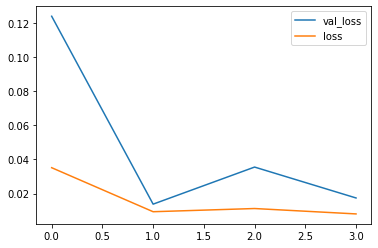

In [27]:
losses.plot()

### Evaluate on Test Data
Forecast predictions for the test data range(-- days of the entire dataset).<br>
Final result will be DataFrame with 2 columns, true test values and the predictions.<br>

In [28]:
"""
evaluate test predictions
"""

test_predictions = []

#last 60 days of train set to predcit 1 day in the future, which is 1st point in test set
#ie 24, would be last 24 days of training data. 24 days to predict 1 day into the future
first_eval_batch = scaled_train[-length:] #should be in last batch if training data
#change 1
# 1 time series per batch(batch_size), length, n_features=1
current_batch = first_eval_batch.reshape((1,length, n_features)) #reshape to correct format. 1 item per batch

for i in range(len(test)): #only forecasting on test set
    #get hte predcition 1 timestamp ahead.
    current_pred = model.predict(current_batch)[0] #to be current prediction
    
    test_predictions.append(current_pred) #take current_pred and append to list
    #in order to keep predicintg into future need to move current batch forward 1 timestep
    #gets rid of 1st item and replaces it with current prediction all the way to the very end
    #drops 1st value in current_batch
    #append curent predcition value. Moves current_batch 1 value into the future
    #true forecast is predciting off predictions
    #1-grab everythin but index 0
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)


In [29]:
#current_batch.shape

In [30]:
true_predictions = scaler.inverse_transform(test_predictions)

In [31]:
test['LSTM Predictions'] = true_predictions

/Users/davidtorres/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [32]:
"""
true and predictions
"""
test.head(25)

,Close,LSTM Predictions
Date,,
2016-10-19,29.280001,29.202742
2016-10-20,29.264999,29.275372
2016-10-21,29.150000,29.344336
2016-10-24,29.412500,29.409014
2016-10-25,29.562500,29.469519
2016-10-26,28.897499,29.526310
2016-10-27,28.620001,29.579980
2016-10-28,28.430000,29.631118
2016-10-31,28.385000,29.680237


<AxesSubplot:xlabel='Date'>

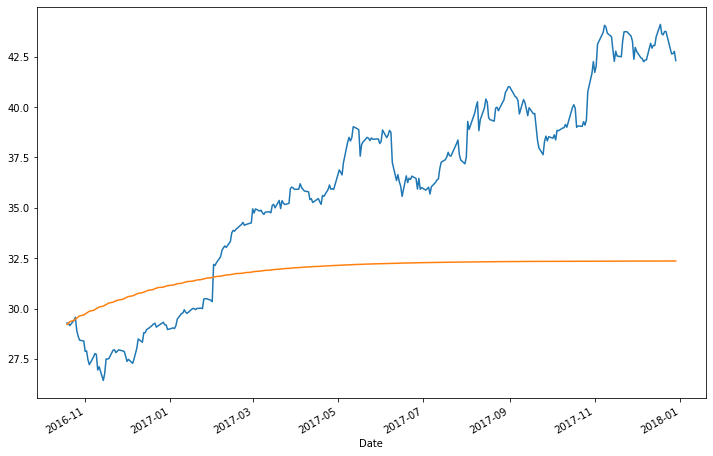

In [33]:
"""
blue is what we know true values for
"""
test['Close'].plot(figsize=(12,8))
test['LSTM Predictions'].plot()

#### Calculate RMSE

In [34]:
from sklearn.metrics import mean_squared_error

In [35]:
#how accurate model predicts reponse
rmse = np.sqrt(mean_squared_error(test['Close'],test['LSTM Predictions']))
rmse

5.967637217179834

## Forecast into Unknown Future

In [43]:
"""
full dataframe transformed
"""
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [44]:
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length=length, batch_size=batch_size)

In [45]:

n_features = 1

model = Sequential()

model.add(LSTM(units = 50, return_sequences = True, input_shape=(length, n_features)))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 50, return_sequences = False))
model.add(Dropout(0.2))

model.add(Dense(units = 25))
model.add(Dense(units = 1))

model.compile(optimizer = 'adam', loss = 'mean_squared_error')


In [46]:
model.fit_generator(generator, epochs=50)

Epoch 1/50
41/41 [==============================] - 36s 874ms/step - loss: 0.0391
Epoch 2/50
41/41 [==============================] - 32s 774ms/step - loss: 0.0040
Epoch 3/50
41/41 [==============================] - 33s 813ms/step - loss: 0.0045
Epoch 4/50
41/41 [==============================] - 30s 743ms/step - loss: 0.0034
Epoch 5/50
41/41 [==============================] - 30s 743ms/step - loss: 0.0034
Epoch 6/50
41/41 [==============================] - 33s 806ms/step - loss: 0.0052
Epoch 7/50
41/41 [==============================] - 32s 791ms/step - loss: 0.0042
Epoch 8/50
41/41 [==============================] - 34s 833ms/step - loss: 0.0027
Epoch 9/50
41/41 [==============================] - 29s 704ms/step - loss: 0.0035
Epoch 10/50
41/41 [==============================] - 33s 805ms/step - loss: 0.0027
Epoch 11/50
41/41 [==============================] - 33s 811ms/step - loss: 0.0028
Epoch 12/50
41/41 [==============================] - 42s 1s/step - loss: 0.0037
Epoch 13/50
41/4

In [59]:
forecast = []
periods = 60 #forecasting off predeiciotns, adding in more predictions
             #forecast length should be the same as test length
            #should equal intial batch length

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    current_pred = model.predict(current_batch)[0] #to be current prediction
    
    forecast.append(current_pred) #take current_pred and append to list
    #in order to keep predicintg into future need to move current batch forward 1 timestep
    #gets rid of 1st item and replaces it with current prediction all the way to the very end
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)


In [60]:
#inverse scale 
forecast = scaler.inverse_transform(forecast)

In [61]:
df

,Close
Date,
2012-01-03,14.686786
2012-01-04,14.765715
2012-01-05,14.929643
2012-01-06,15.085714
2012-01-09,15.061786
...,...
2017-12-22,43.752499
2017-12-26,42.642502
2017-12-27,42.650002


In [62]:
#going into 2020
forecast

array([[32.05548322],
       [31.92575189],
       [31.7947849 ],
       [31.66574043],
       [31.53966315],
       [31.41669226],
       [31.296646  ],
       [31.17928504],
       [31.06437354],
       [30.95172626],
       [30.84117177],
       [30.73255016],
       [30.62572105],
       [30.52054984],
       [30.41691457],
       [30.3147094 ],
       [30.21382732],
       [30.11419586],
       [30.01573448],
       [29.91838564],
       [29.82209413],
       [29.72681854],
       [29.63251743],
       [29.53916204],
       [29.44672362],
       [29.35517915],
       [29.26450793],
       [29.17468464],
       [29.08570353],
       [28.99754043],
       [28.91017465],
       [28.82360503],
       [28.73780855],
       [28.65277257],
       [28.56848557],
       [28.48493491],
       [28.40209872],
       [28.31998045],
       [28.23855594],
       [28.157816  ],
       [28.07774795],
       [27.99834031],
       [27.91958385],
       [27.84146364],
       [27.7639716 ],
       [27

In [63]:
#len(forecast)

In [68]:
#build forecast index
#forecasting off predictions
#period should be equal to intial batch ength
forecast_index = pd.date_range(start='2019-01-18',periods=periods, freq='B')

In [69]:
forecast_index

DatetimeIndex(['2019-01-18', '2019-01-21', '2019-01-22', '2019-01-23',
               '2019-01-24', '2019-01-25', '2019-01-28', '2019-01-29',
               '2019-01-30', '2019-01-31', '2019-02-01', '2019-02-04',
               '2019-02-05', '2019-02-06', '2019-02-07', '2019-02-08',
               '2019-02-11', '2019-02-12', '2019-02-13', '2019-02-14',
               '2019-02-15', '2019-02-18', '2019-02-19', '2019-02-20',
               '2019-02-21', '2019-02-22', '2019-02-25', '2019-02-26',
               '2019-02-27', '2019-02-28', '2019-03-01', '2019-03-04',
               '2019-03-05', '2019-03-06', '2019-03-07', '2019-03-08',
               '2019-03-11', '2019-03-12', '2019-03-13', '2019-03-14',
               '2019-03-15', '2019-03-18', '2019-03-19', '2019-03-20',
               '2019-03-21', '2019-03-22', '2019-03-25', '2019-03-26',
               '2019-03-27', '2019-03-28', '2019-03-29', '2019-04-01',
               '2019-04-02', '2019-04-03', '2019-04-04', '2019-04-05',
      

In [70]:
forecast_df = pd.DataFrame(data=forecast,index=forecast_index, columns=['Forecast'])

<AxesSubplot:>

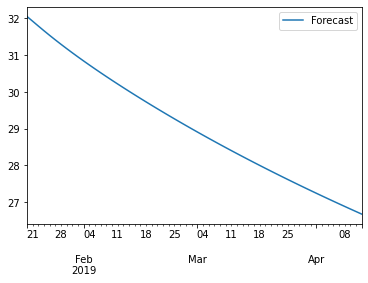

In [71]:
forecast_df.plot()

In [72]:
# ax=df.plot()
# forecast_df.plot(ax=ax)

<AxesSubplot:xlabel='Date'>

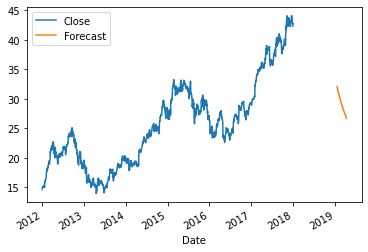

In [73]:
ax=df.plot()
forecast_df.plot(ax=ax)
#plt.xlim('2019-12-18','2020-04-01')